In [3]:
import os
import pandas as pd
from sklearn.utils import shuffle

# ✅ Your root path
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

# ✅ Helper: create DataFrame with selected N images per class
def create_df_from_directory(base_dir, classes, samples_per_class):
    data = []
    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        all_images = os.listdir(class_dir)
        selected_images = sorted(all_images)[:samples_per_class]
        for img in selected_images:
            data.append((os.path.join(class_dir, img), class_name))
    return pd.DataFrame(data, columns=['filename', 'class'])

# ✅ Get sorted class list from training folder
class_names = sorted(os.listdir(train_dir))

# ✅ Create DataFrames
train_df = create_df_from_directory(train_dir, class_names, 300)
val_df   = create_df_from_directory(val_dir, class_names, 100)
test_df  = create_df_from_directory(test_dir, class_names, 50)

# ✅ Shuffle DataFrames
train_df = shuffle(train_df, random_state=SEED)
val_df = shuffle(val_df, random_state=SEED)
test_df = shuffle(test_df, random_state=SEED)


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess, DenseNet121
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess, EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# For MobileNetV2
train_datagen_efficientnet = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    zoom_range=0.3,
    shear_range=0.3,
)

val_test_datagen_efficientnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

# For ResNet50
train_datagen_densenet = ImageDataGenerator(
    preprocessing_function=densenet_preprocess,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    zoom_range=0.3,
    shear_range=0.3,
)

val_test_datagen_densenet = ImageDataGenerator(preprocessing_function=densenet_preprocess)

# For simple normalization
train_datagen_normal = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    zoom_range=0.3,
    shear_range=0.3,
)

val_test_datagen_normal = ImageDataGenerator(rescale=1./255)

# ✅ Flow from directory

def make_generator(datagen, data_df, name='train'):
    return datagen.flow_from_dataframe(
        dataframe=data_df,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        x_col='filename',
        y_col='class',
        class_mode='categorical',
        shuffle=True if name == 'train' else False,
        seed=SEED
    )

# ✅ Create generators

# For MobileNet
train_ds_efficientnet = make_generator(train_datagen_efficientnet, train_df, 'train')
val_ds_efficientnet = make_generator(val_test_datagen_efficientnet, val_df, 'val')
test_ds_efficientnet = make_generator(val_test_datagen_efficientnet, test_df, 'test')

# For ResNet
train_ds_densenet = make_generator(train_datagen_densenet, train_df, 'train')
val_ds_densenet = make_generator(val_test_datagen_densenet, val_df, 'val')
test_ds_densenet = make_generator(val_test_datagen_densenet, test_df, 'test')

# For Normal model (no pre-trained base)
train_ds_normal = make_generator(train_datagen_normal, train_df, 'train')
val_ds_normal = make_generator(val_test_datagen_normal, val_df, 'val')
test_ds_normal = make_generator(val_test_datagen_normal, test_df, 'test')


Found 3000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.
Found 500 validated image filenames belonging to 10 classes.
Found 3000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.
Found 500 validated image filenames belonging to 10 classes.
Found 3000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.
Found 500 validated image filenames belonging to 10 classes.


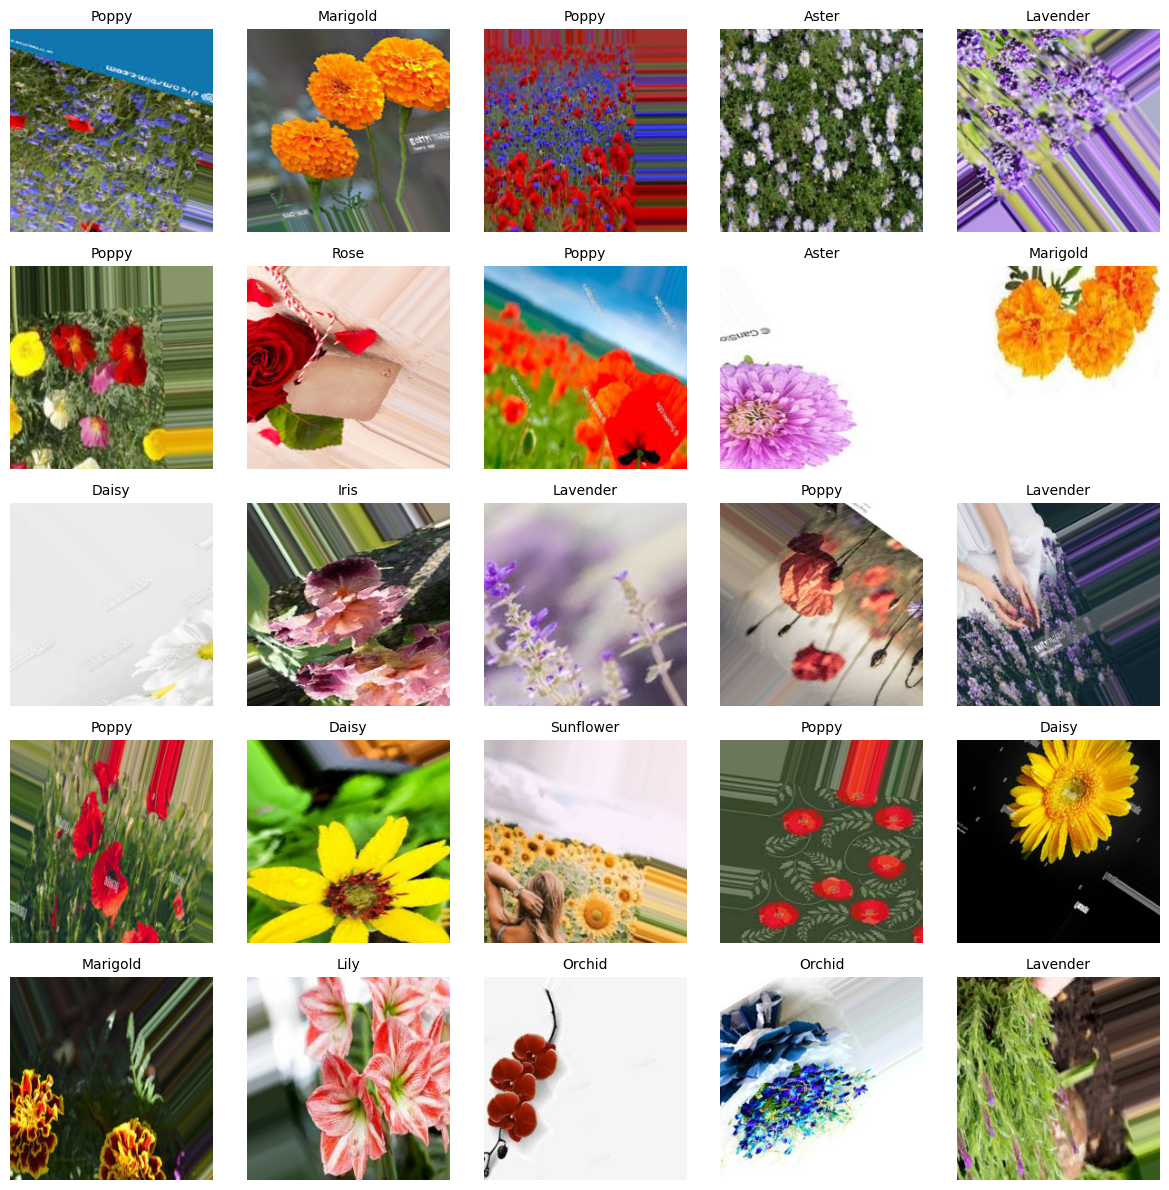

In [5]:
# Get a batch of images and labels
images, labels = next(train_ds_normal)

# Get class names from the generator
class_names = list(train_ds_normal.class_indices.keys())

# Plot 25 images
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])  # Convert one-hot to index
    plt.title(class_names[label_index], fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

def create_pretrained_model(base_model_name='ResNet50'):
    """Create fine-tuned pretrained model"""

    if base_model_name == 'EfficientNetB1':
        base_model = EfficientNetB1(weights='imagenet', include_top=False,
                              input_shape=(224, 224, 3))
    elif base_model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False,
                          input_shape=(224, 224, 3))
    else:
        raise ValueError("Unsupported base model")

    # Freeze all layers except the last few
    for layer in base_model.layers[:-5]:  # Freeze all but last 2 layers
        layer.trainable = False

    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    return model


def create_small_cnn():
        """Create small custom CNN architecture"""
        model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
        layers.MaxPooling2D((2,2)),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

        return model


In [7]:
teacher1 = create_pretrained_model('EfficientNetB1')
teacher2 = create_pretrained_model('DenseNet121')
student= create_small_cnn()

teacher1.summary()
teacher2.summary()
student.summary()

2025-07-28 11:47:51.846073: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-28 11:47:52.281781: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-28 11:47:52.281964: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)     │ (None, 7, 7, 1280)     │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,422,033 (32.13 MB)

 Trainable params: 2,256,394 (8.61 MB)

 Non-trainable params: 6,165,639 (23.52 MB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,621,130 (32.89 MB)

 Trainable params: 1,620,490 (6.18 MB)

 Non-trainable params: 7,000,640 (26.71 MB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,706 (381.66 KB)

 Trainable params: 97,706 (381.66 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
base_learning_rate = 0.0001

teacher1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
teacher2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

history1=teacher1.fit(
    train_ds_efficientnet,
    validation_data=val_ds_efficientnet,
    steps_per_epoch=len(train_ds_efficientnet),
    epochs=20,
)
history2=teacher2.fit(
    train_ds_densenet,
    validation_data=val_ds_densenet,
    steps_per_epoch=len(train_ds_densenet),
    epochs=20,
)
history3=student.fit(
    train_ds_normal,
    validation_data=val_ds_normal,
    steps_per_epoch=len(train_ds_normal),
    epochs=20,
)

/home/cse/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-07-28 11:48:07.587026: I external/local_xla/xla/service/service.cc:168] XLA service 0x57138f6d2490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-28 11:48:07.587052: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2025-07-28 11:48:08.078767: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-28 11:48:11.339244: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


 2/94 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.1328 - loss: 2.5924    

I0000 00:00:1753681723.152493    4270 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 117s 767ms/step - accuracy: 0.2773 - loss: 2.2845 - val_accuracy: 0.5820 - val_loss: 1.5903
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 289ms/step - accuracy: 0.6501 - loss: 1.3701 - val_accuracy: 0.6410 - val_loss: 1.2234
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 261ms/step - accuracy: 0.7219 - loss: 1.0732 - val_accuracy: 0.6600 - val_loss: 1.1442
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 256ms/step - accuracy: 0.7860 - loss: 0.8762 - val_accuracy: 0.6770 - val_loss: 1.0987
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 256ms/step - accuracy: 0.8053 - loss: 0.8053 - val_accuracy: 0.6930 - val_loss: 1.0819
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 261ms/step - accuracy: 0.8314 - loss: 0.7529 - val_accuracy: 0.7030 - val_loss: 1.0755
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 265ms/step - accuracy: 0.8316 - loss: 0.7061 - val_accuracy: 0.7130 - val_loss: 1.0505
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - accuracy: 0.8390 - loss: 0.6929 - val_accuracy: 0.71

In [9]:
import keras
from keras import layers
from keras import ops

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):

        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            ops.softmax(teacher_pred / self.temperature, axis=1),
            ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)


In [10]:
distilled_model1 = Distiller(student=student, teacher=teacher1)
distilled_model2 = Distiller(student=student, teacher=teacher2)
distilled_model1.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

distilled_model2.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)


history4=distilled_model1.fit(
    train_ds_efficientnet,
    validation_data=val_ds_efficientnet,
    steps_per_epoch=len(train_ds_efficientnet),
    epochs=20,
)

history5=distilled_model2.fit(
    train_ds_densenet,
    validation_data=val_ds_densenet,
    steps_per_epoch=len(train_ds_densenet),
    epochs=20,
)

Epoch 1/20


/home/cse/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:675: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 467ms/step - accuracy: 0.3503 - loss: 3.7022 - val_accuracy: 0.2960 - val_loss: 0.2206
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 275ms/step - accuracy: 0.2921 - loss: 0.1999 - val_accuracy: 0.3360 - val_loss: 0.1967
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 267ms/step - accuracy: 0.3099 - loss: 0.1875 - val_accuracy: 0.3500 - val_loss: 0.2013
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 276ms/step - accuracy: 0.3599 - loss: 0.1843 - val_accuracy: 0.3500 - val_loss: 0.1946
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 262ms/step - accuracy: 0.3975 - loss: 0.1758 - val_accuracy: 0.3620 - val_loss: 0.1863
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 270ms/step - accuracy: 0.4311 - loss: 0.1675 - val_accuracy: 0.4120 - val_loss: 0.1802
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 272ms/step - accuracy: 0.4636 - loss: 0.1657 - val_accuracy: 0.3600 - val_loss: 0.1872
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 267ms/step - accuracy: 0.4473 - loss: 0.1571 - val_accuracy: 0.380

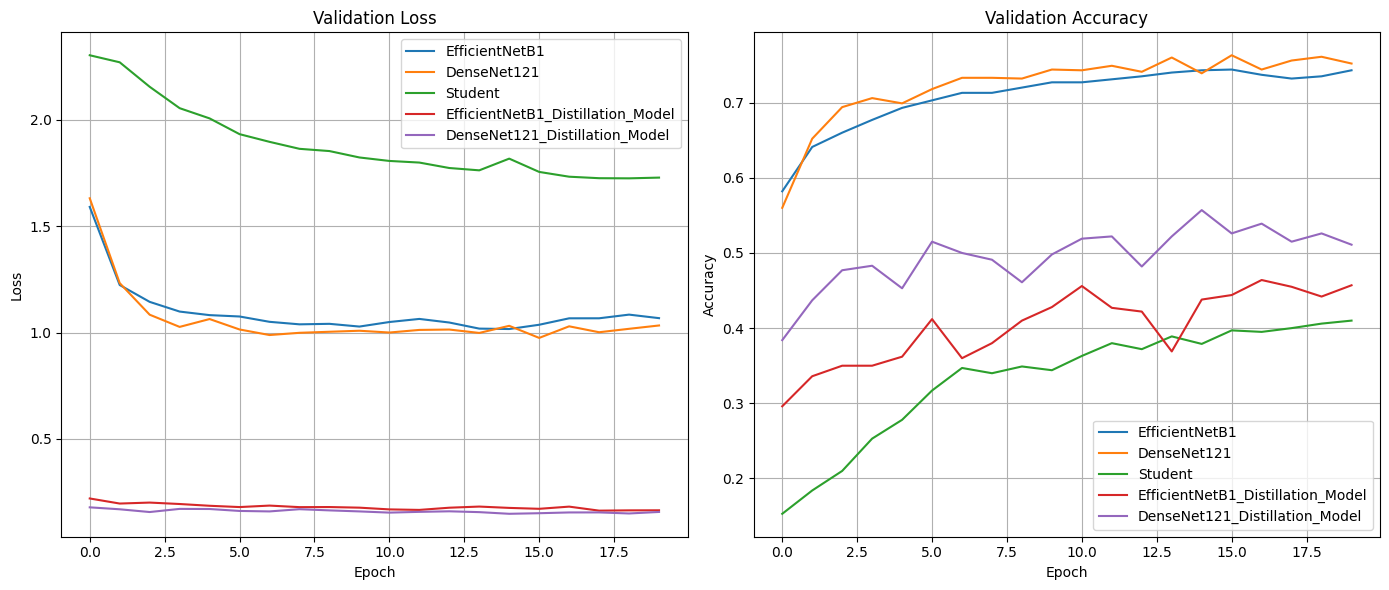

In [11]:
import matplotlib.pyplot as plt

# Create a single figure with 2 subplots: one for loss, one for accuracy
plt.figure(figsize=(14, 6))

# --- Subplot 1: Validation Loss ---
plt.subplot(1, 2, 1)
plt.plot(history1.history['val_loss'], label='EfficientNetB1')
plt.plot(history2.history['val_loss'], label='DenseNet121')
plt.plot(history3.history['val_loss'], label='Student')
plt.plot(history4.history['val_loss'], label='EfficientNetB1_Distillation_Model')
plt.plot(history5.history['val_loss'], label='DenseNet121_Distillation_Model')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Subplot 2: Validation Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history1.history['val_accuracy'], label='EfficientNetB1')
plt.plot(history2.history['val_accuracy'], label='DenseNet121')
plt.plot(history3.history['val_accuracy'], label='Student')
plt.plot(history4.history['val_accuracy'], label='EfficientNetB1_Distillation_Model')
plt.plot(history5.history['val_accuracy'], label='DenseNet121_Distillation_Model')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and save
plt.tight_layout()
plt.savefig("loss_accuracy_subplots.png", dpi=300, bbox_inches='tight')
plt.show()


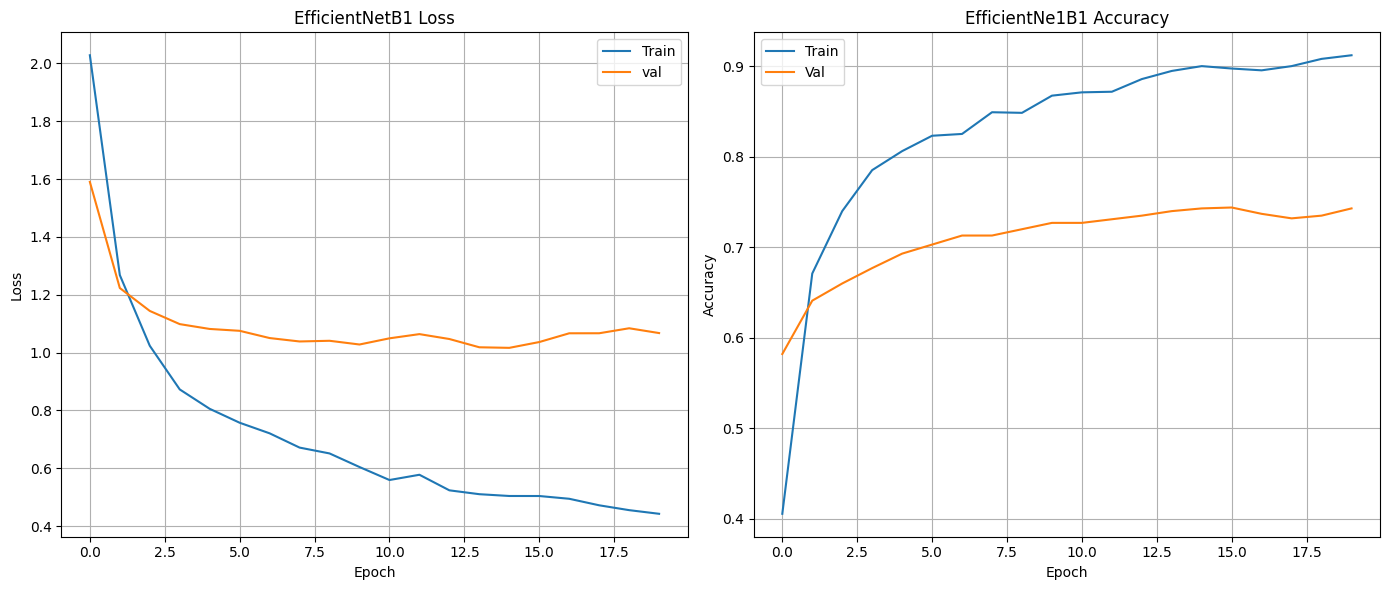

In [12]:
import matplotlib.pyplot as plt

# Create a single figure with 2 subplots: one for loss, one for accuracy
plt.figure(figsize=(14, 6))

# --- Subplot 1: Validation Loss ---
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train')
plt.plot(history1.history['val_loss'], label='val')
plt.title('EfficientNetB1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Subplot 2: Validation Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Train')
plt.plot(history1.history['val_accuracy'], label='Val')
plt.title('EfficientNe1B1 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and save
plt.tight_layout()
plt.savefig("loss_accuracy_subplots1.png", dpi=300, bbox_inches='tight')
plt.show()


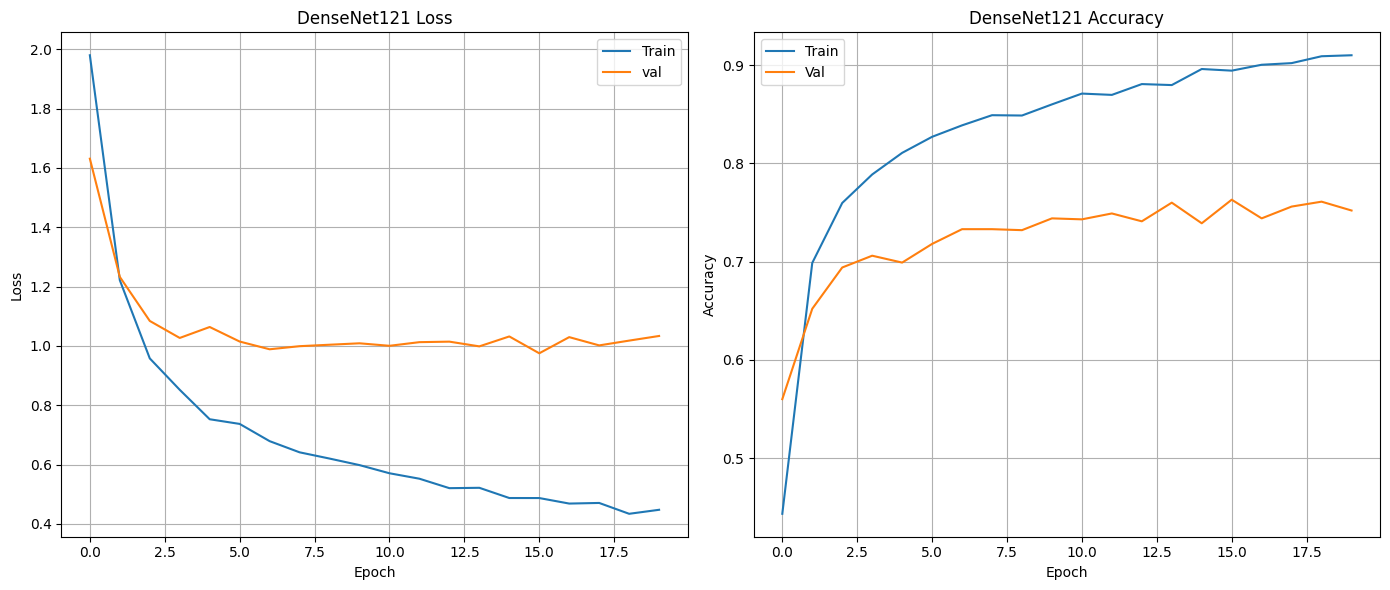

In [13]:
import matplotlib.pyplot as plt

# Create a single figure with 2 subplots: one for loss, one for accuracy
plt.figure(figsize=(14, 6))

# --- Subplot 1: Validation Loss ---
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='val')
plt.title('DenseNet121 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Subplot 2: Validation Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Val')
plt.title('DenseNet121 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and save
plt.tight_layout()
plt.savefig("loss_accuracy_subplots2.png", dpi=300, bbox_inches='tight')
plt.show()


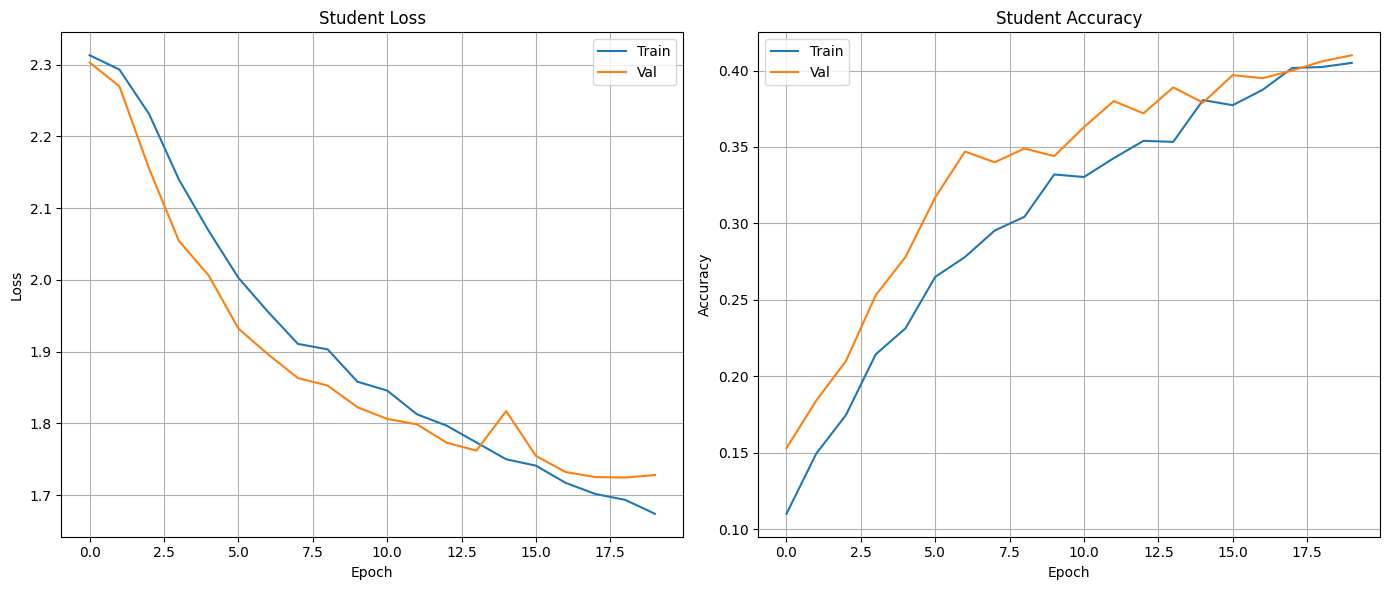

In [14]:
import matplotlib.pyplot as plt

# Create a single figure with 2 subplots: one for loss, one for accuracy
plt.figure(figsize=(14, 6))

# --- Subplot 1: Validation Loss ---
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Train')
plt.plot(history3.history['val_loss'], label='Val')
plt.title('Student Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Subplot 2: Validation Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='Train')
plt.plot(history3.history['val_accuracy'], label='Val')
plt.title('Student Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and save
plt.tight_layout()
plt.savefig("loss_accuracy_subplots3.png", dpi=300, bbox_inches='tight')
plt.show()


In [15]:
test_acc1,test_loss1=teacher1.evaluate(test_ds_efficientnet)
test_acc2,test_loss2=teacher2.evaluate(test_ds_densenet)
test_acc3,test_loss3=student.evaluate(test_ds_normal)
test_acc4,test_loss4=distilled_model1.evaluate(test_ds_efficientnet)
test_acc5,test_loss5=distilled_model2.evaluate(test_ds_densenet)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 636ms/step - accuracy: 0.5455 - loss: 1.6170
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6265 - loss: 1.5418
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.1022 - loss: 3.0271
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.3697 - loss: 5.8032
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.5748 - loss: 0.1481


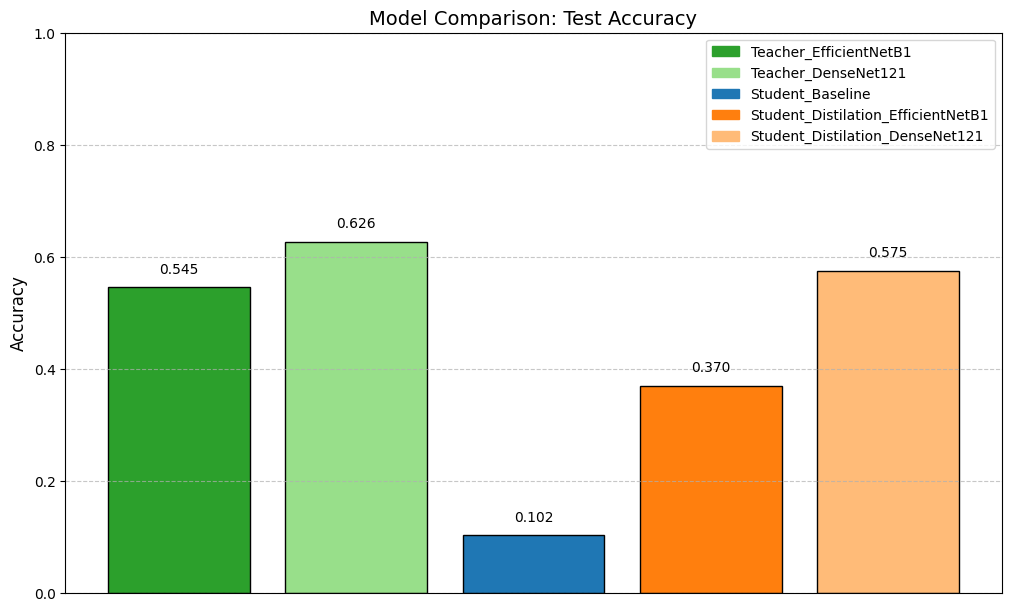

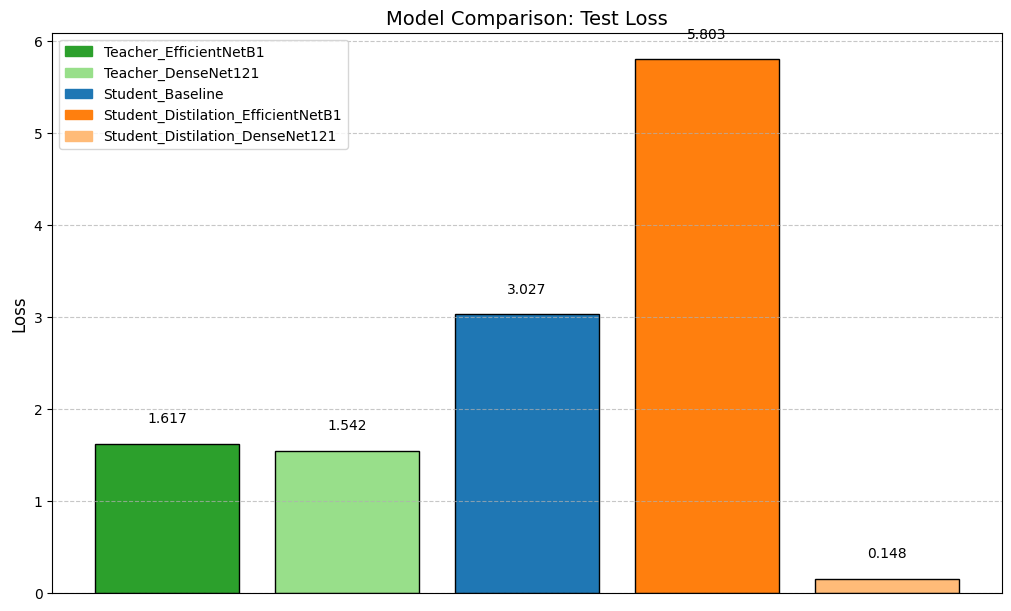

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Actual test results
test_losses = [1.6170, 1.5418, 3.0271, 5.8032, 0.1481]
test_accuracies = [0.5455, 0.6265, 0.1022, 0.3697, 0.5748]

# Define the final results
data = {
    "Model": [
        "Teacher_EfficientNetB1",
        "Teacher_DenseNet121",
        "Student_Baseline",
        "Student_Distilation_EfficientNetB1",
        "Student_Distilation_DenseNet121"
    ],
    "Test Loss": test_losses,
    "Test Accuracy": test_accuracies
}

# Create DataFrame
df = pd.DataFrame(data)

# Define colors by group
color_map = {
    "Teacher_EfficientNetB1": "#2ca02c",                        
    "Teacher_DenseNet121": "#98df8a",                  
    "Student_Baseline": "#1f77b4",                    
    "Student_Distilation_EfficientNetB1": "#ff7f0e",     
    "Student_Distilation_DenseNet121": "#ffbb78"       
}
colors = [color_map[model] for model in df["Model"]]

# Labels for legend
legend_labels = {model: model for model in df["Model"]}

# ----- Plot 1: Test Accuracy -----
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
bars = ax.bar(range(len(df)), df["Test Accuracy"], color=colors, edgecolor='black')

# Title and Labels
ax.set_title("Model Comparison: Test Accuracy", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xticks([])

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
            f"{height:.3f}", ha='center', va='bottom', fontsize=10)

# Legend
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[model]) for model in df["Model"]]
legend_names = [legend_labels[model] for model in df["Model"]]
ax.legend(legend_handles, legend_names, loc='upper right', fontsize=10)

plt.show()

# ----- Plot 2: Test Loss -----
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
bars = ax.bar(range(len(df)), df["Test Loss"], color=colors, edgecolor='black')

# Title and Labels
ax.set_title("Model Comparison: Test Loss", fontsize=14)
ax.set_ylabel("Loss", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xticks([])

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.2,
            f"{height:.3f}", ha='center', va='bottom', fontsize=10)

# Legend
ax.legend(legend_handles, legend_names, loc='upper left', fontsize=10)

plt.show()
